In [15]:
%matplotlib inline
### Interactive medword testing tool ###

import preprocess as pp
import embedding
import model_validation as mv
import shared.load_config 
import json
import pylab
import os
import word2vec as w2v

pp.setup()

In [16]:
### script settings ###

# if you want to compute new training data from raw-data
COMPUTE_NEW_TRAIN_DATA = True
# note: if you don't compute new training data, you must provide them
#       at train_data_src for training a new model


# if you want to train a new model on training data
TRAIN_NEW_MODEL = True
# note: if you don't train a new model, you must provide it
#       at emb_model_src for the validation step

In [17]:
### define filepaths and names ###
#
# Note: when generating training data, all *.txt files in any subdirectory of 
#       raw_data_dir are considered. If you save the generated train_data in the
#       same folder (raw_data_dir), it will be used as raw_data input in a 
#       following run (undesired).

# where to get the configuration file
config_data_dir = ''
config_filename = 'configuration.json'

# where to get the raw *txt files for preprocessing
raw_data_dir = 'dev_data/train_data/raw_data/'

# where to store preprocessing output
train_data_src = 'dev_data/train_data/train.txt'

# where to store trained embedding model
emb_model_dir = 'dev_data/embeddings/'
emb_model_filename = 'emb_model.bin'
emb_model_src = os.path.join(emb_model_dir, emb_model_filename)

# Load configuration (don't change)
config_src = os.path.join(config_data_dir, config_filename)
config = shared.load_config.Configuration(config_src)

In [18]:
### choose your tokenizer for the prepocessing and validation ###

## NonStemmingTokenizer: 'nst'
# - no stemming, only remove punctuation marks
# - lowercase letters
config.config['tokenizer'] = 'nst'

## SimpleGermanTokenizer: 'sgt'
# - remove punctuation marks
# - stemming
# - lowercase letters
# config.config['tokenizer'] = 'sgt'

# test the chosen tokenizer
tokenizer = pp.get_tokenizer(config)
example = """!! „asdf“ 'asdf' "asdf" ??Ein Arzt bzw. eine Ärztin ist ein medizinisch\n \n 
             ausgebildeter Heilkundiger, beschäftigt sich mit der
             Vorbeugung (Prävention), [Erkennung] (Diagnose),
             Behandlung (Therapie) [...] und Nachsorge von Krankheiten
             und Leiden bzw. gesundheitlichen Beeinträchtigungen,
             und stellt sich damit in den Dienst der Gesundheit."""
             
tk_example = tokenizer.tokenize(str(example))

print(tk_example)

['asdf', 'asdf', 'asdf', 'ein', 'arzt', 'bzw', 'eine', 'aerztin', 'ist', 'ein', 'medizinisch', 'ausgebildeter', 'heilkundiger', 'beschaeftigt', 'sich', 'mit', 'der', 'vorbeugung', 'praevention', 'erkennung', 'diagnose', 'behandlung', 'therapie', 'und', 'nachsorge', 'von', 'krankheiten', 'und', 'leiden', 'bzw', 'gesundheitlichen', 'beeintraechtigungen', 'und', 'stellt', 'sich', 'damit', 'in', 'den', 'dienst', 'der', 'gesundheit']


In [19]:
### compute new training data from raw *txt files ###

# compute new train data if needed
if (COMPUTE_NEW_TRAIN_DATA):
    pp.create_train_data(train_data_src, raw_data_dir, config)

Creating new training data. 
Using this Tokenizer:  NonStemmingTokenizer
Making tokenSet from directory ' dev_data/train_data/raw_data/ '
Found 2626 different tokens in 17 articles, total training size: 6495 tokens.


In [20]:
### train a new model on your training data ###
# note: the used configuration file is saved together with the model
#       in the emb_model_dir
#

# dimension of embedding vectors
config.config['embedding_vector_dim'] = 400

# minimum number of appearence fore a token to be considered in the 
# model (you may want to ignore rare tokens)
config.config['min_token_appearance'] = 1


# train embeddings using word2vec
if (TRAIN_NEW_MODEL):
    embedding.make_emb_from_file(train_data_src, emb_model_dir, emb_model_filename, config)

Start training the model.
Training finsihed. 
Model saved at: dev_data/embeddings/emb_model.bin


In [10]:
### Validation of the embedding model ###

# Choose test files from your validation folder
config.config['doesntfit_file'] = 'german_doesntfit1.txt'
config.config['synonyms_file'] = 'german_synonyms3.txt'


model = mv.validate_model(emb_model_src, config)

Start validation. Loading model. 

Validating 'doesntfit' with file data/validation_data/german_doesntfit1.txt

*** Doesn't fit ***
Doesn't fit correct:  33.3% (1/3)
Doesn't fit coverage: 2.7% (3/110) 

Validating 'synonyms' with file data/validation_data/german_synonyms3.txt
Synonyms: 42175 pairs in input. 8 pairs in model-vocabulary.

*** Cosine-Similarity ***
Synonyms avg-cos-similarity (SACS): 0.102488938867 
Random avg-cos-similarity (RACS): 0.000803612063915 
Ratio SACS/RACS: 127.535341328

*** Synonym Recognition ***
Synonyms correct:  0.0% (0/16), checked 40 closest embedding-vectors.checked per word.
Synonyms coverage: 0.0% (16/84350)



In [21]:
### Get model information ###
print("vocab_size:", model.vocab.size)  # note that the token '</s>' is 
                                        # always added to the model
    
print("vectors_shape:", model.vectors.shape)

vocab_size: 2627
vectors_shape: (2627, 400)


In [22]:
### Play with model ###

# define a word from which you like to see it's n-nearest neighbours 
# in the embedding space
word = 'arzt'
n_nearest_neighbours = 10

# create list of neighbours
indexes, metrics = model.cosine(word, n_nearest_neighbours)
model.generate_response(indexes, metrics).tolist()

[('konzepte', 0.14198459619101203),
 ('aufgefasst', 0.13929239676179403),
 ('ernaehrungsreform', 0.13558294221976325),
 ('wesentlichen', 0.12781836202735872),
 ('heinz', 0.12737330027692342),
 ('technischen', 0.12616133953016065),
 ('dr', 0.12572437557438748),
 ('ferrara', 0.12471720850043111),
 ('richtet', 0.12371120947431118),
 ('externum', 0.1218850779960024)]

In [23]:
# Get a vector of a word
vec1 = model['arzt'] 
# or
vec2 = model.get_vector('arzt')

print(vec1[:10])

[ 0.02345062  0.05238208  0.04931071 -0.06052622  0.03699357  0.03486539
  0.07702528 -0.08502589  0.08610728 -0.02612908]


In [24]:
### Load model separately if desired ###
# note: also loaded in mv.validate_model() ###
model = w2v.load(emb_model_src)

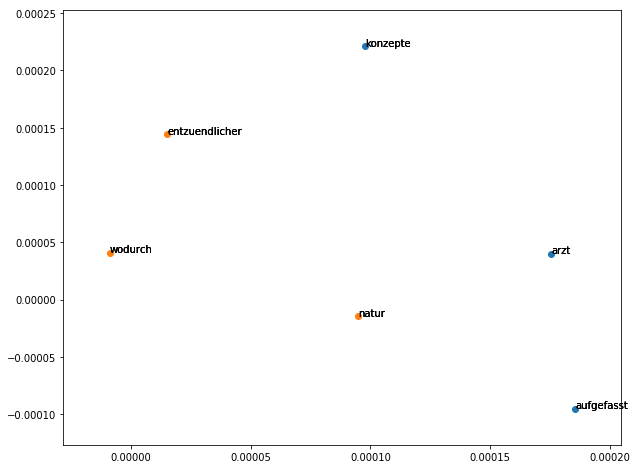

In [25]:
### Visualization ###
# From a list of words, plot all words and it's neighbours 

# define the words you would like to visualize
word_list = ['arzt', 'haus', 'natur']

# define the number of closest neighbors to display per word
n_nearest_neighbours = 5

# change figure size if desired
width = 10.0
height = 8.0
pylab.rcParams['figure.figsize'] = (width, height)

# plotting
mv.visualize_words(model, word_list, n_nearest_neighbours)